In [59]:
import ira

from tqdm.notebook import tqdm
%alphalab dark

import qlearn as q
from c3p.models.utils import prepare_data

%run models.py

In [60]:
def simulate_models(data, model, contracts, spread=0.5, commissions=0.075, timeframe='1h'):
    contracts = contracts if isinstance(contracts, list) else [contracts]
    
    if data.conv_symbol:
        cdata = data.conv_data.ohlc(timeframe)
        test_data = data.data.ohlc(timeframe)

        ci = cdata[data.conv_symbol][['open', 'high', 'low', 'close']]
        new_data = {k: scols(v[['open', 'high', 'low', 'close']] * ci, v['volume']).dropna() 
                    for k,v in test_data.items() if k != data.underlying}
        test_data = {**new_data, **{data.underlying: test_data[data.underlying]}}
    else:
        test_data = data.data.ohlc(timeframe)
    
    # preparing models 
    models = {c.name: q.PortfolioComposer(model).select([c.name, c.underlying]).fit(test_data) for c in contracts}
    
    # run all simulations
    rs = q.simulation(models, test_data, 'crypto_futures', spreads=spread)
    return rs

def simulate_rolling_model(data, model, spread=0.5, commissions=0.075, timeframe='1h') -> mstruct:
    # run all contracts
    rs = simulate_models(data, model, data.ctrs, spread, commissions, timeframe)
    
    xbt_pfl = None
    rest_pfl = None
    for r in rs.results:
        if len(r.executions) > 0:
            p = r.get_portfolio(commissions=commissions)
            pxbt = p.filter(regex=f'{data.underlying}_.*')
            rest_pfl = scols(rest_pfl, p.filter(regex=f"^(?!{data.underlying}).*?$"))
            
            if xbt_pfl is None:
                xbt_pfl = pxbt
            else:
                _p = scols(xbt_pfl, pxbt, keys=['A', 'B']).fillna(0)
                xbt_pfl = _p.A + _p.B

    total_protfolio = scols(xbt_pfl, rest_pfl) 
    
    f_name = ' -> '.join([str(v).replace(' ', '').replace('\n', '') for k, v in model.steps])
    return mstruct(portfolio=total_protfolio, name=f_name, simulations=rs)

# XBTUSD
<hr/>

In [3]:
d = prepare_data('XBTUSD')

In [61]:
r_xbt1 = simulate_rolling_model(d, q.make_pipeline(
    SpreadMaker(AbsSpreadCalculator(), PeriodSmoother('7d', 'ema')),
    SimpleSpreadTrader(1000, 80, 0)))


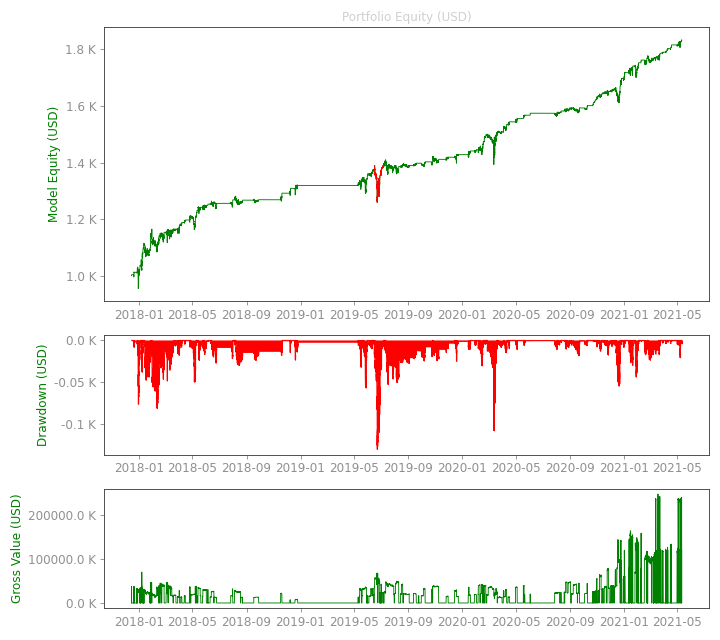

<Figure size 720x640 with 0 Axes>

In [62]:
tearsheet(r_xbt1, 1000)

<hr/>

In [43]:
r_xbt2 = simulate_rolling_model(d, q.make_pipeline(
    SpreadMaker(PctSpreadCalculator(True), PeriodSmoother('7d', 'ema')), 
    SimpleSpreadTrader(1000, 0.015, 0)))


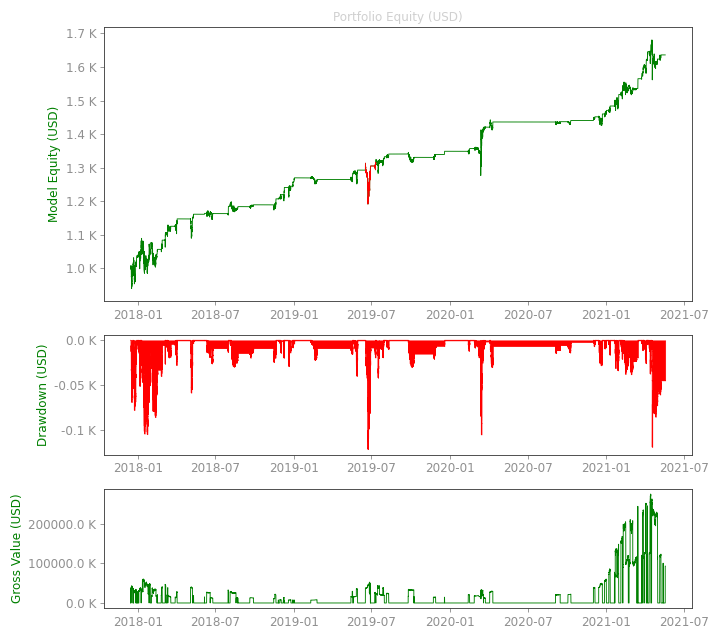

<Figure size 720x640 with 0 Axes>

In [44]:
tearsheet(r_xbt2, 1000)

<hr/>

In [45]:
r_xbt3 = simulate_rolling_model(d, q.make_pipeline(
    SpreadMaker(PctSpreadCalculator(True), KalmanSmoother(1e-6, 1)), 
    SimpleSpreadTrader(1000, 0.015, 0)))


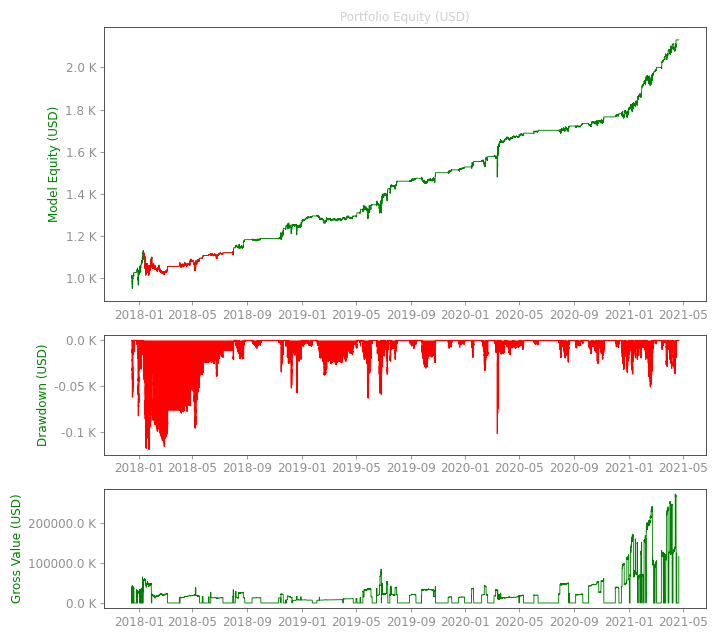

<Figure size 720x640 with 0 Axes>

In [46]:
tearsheet(r_xbt3, 1000)

<hr/>

In [47]:
r_xbt4 = simulate_rolling_model(d, q.make_pipeline(
    SpreadMaker(PctSpreadCalculator(False), KalmanSmoother(1e-6, 1)), 
    SimpleSpreadTrader(1000, 0.015, 0)))


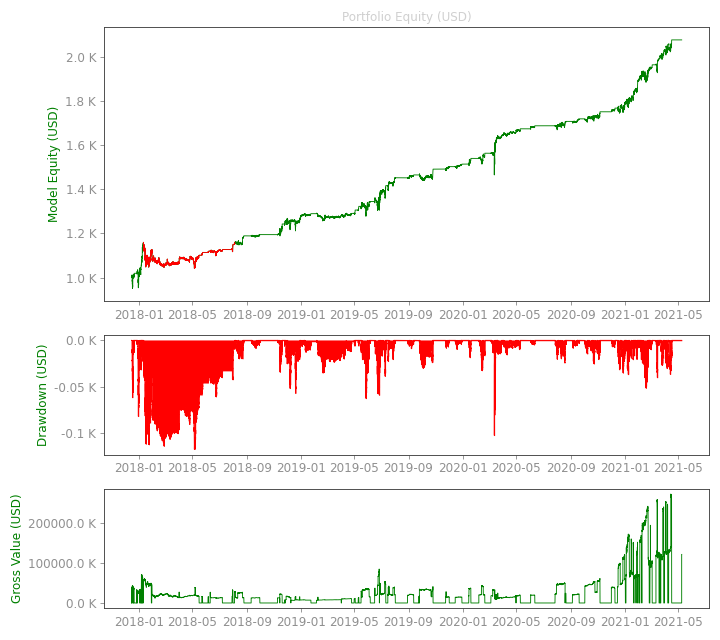

<Figure size 720x640 with 0 Axes>

In [48]:
tearsheet(r_xbt4, 1000)

# ETHUSD
<hr/>

In [74]:
d_eth = prepare_data('ETHUSD', 'XBTUSD')

2021-06-03 12:50:10,930 - ira.simulator.SignalTester - WARNING - Can't find prices for signals at time [2018-03-30 12:48:00.001000]
2021-06-03 12:50:17,529 - ira.simulator.SignalTester - WARNING - Can't find prices for signals at time [2021-05-18 23:48:00.001000]
2021-06-03 12:50:18,226 - ira.simulator.SignalTester - WARNING - Can't find prices for signals at time [2018-06-29 12:48:00.001000]
2021-06-03 12:50:24,547 - ira.simulator.SignalTester - WARNING - Can't find prices for signals at time [2021-05-18 23:48:00.001000]



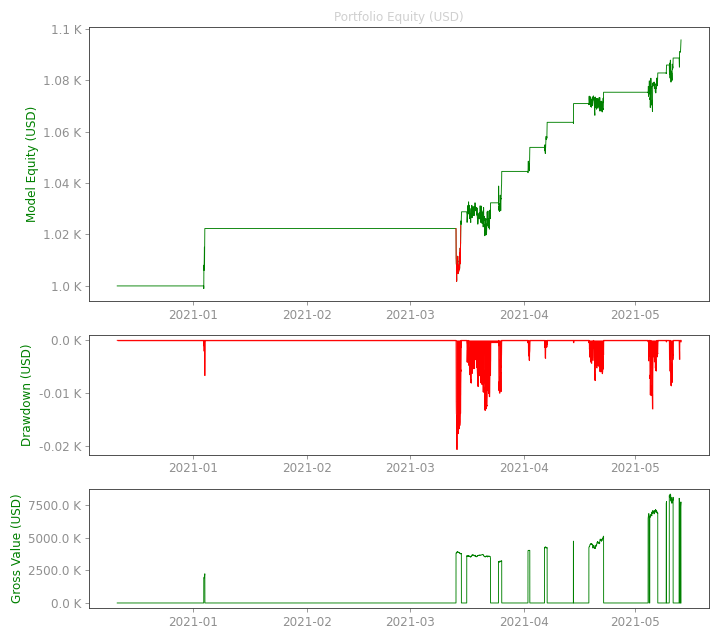

<Figure size 720x640 with 0 Axes>

In [78]:
r_eth1 = simulate_rolling_model(d_eth, q.make_pipeline(
    SpreadMaker(AbsSpreadCalculator(), PeriodSmoother('5d', 'ema')),
    SimpleSpreadTrader(1000, 20, 0)))

tearsheet(r_eth1, 1000)

In [76]:
r_eth2 = simulate_rolling_model(d_eth, q.make_pipeline(
    SpreadMaker(PctSpreadCalculator(), PeriodSmoother('5d', 'ema')),
    SimpleSpreadTrader(1000, 0.01, 0)))

tearsheet(r_eth2, 1000)

In [58]:
r_eth3 = simulate_rolling_model(d_eth, q.make_pipeline(
    SpreadMaker(PctSpreadCalculator(True), KalmanSmoother(1e-6, 1)), 
    SimpleSpreadTrader(1000, 0.01, 0)))

tearsheet(r_eth3, 1000)

# Validation

In [67]:
v = simulate_models(d, q.make_pipeline(SpreadMaker(AbsSpreadCalculator(), PeriodSmoother('7d', 'ema')), 
                                       SimpleSpreadTrader(1000, 80, 0)), 
                    d.ctrs[-1])

In [ ]:
ex = v.results[0].executions
ex[ex.instrument=='XBTUSD']